# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

You should produce a Jupyter notebook and a `.txt` file (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

Place your notebook and `.txt` files **only** in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 3 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [107]:
from __future__ import print_function, division

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score
from sklearn.cross_validation import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, RobustScaler
from numpy import unravel_index
import seaborn as sns
from sklearn.decomposition import PCA
from seaborn import heatmap
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
print('done w/ import')

done w/ import


## Description of the dataset
In this assignment our goal is to recognize objects from 19 dierent visual classes (e.g. person, dog, cat, car, ...) in realistic scenes. The dataset consists of several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

Here we will focus on a single classiffication task: you will be required to classify images as to whether or not they contain a person. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. That is, each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 diffeerent visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image). Our dataset with all images is thus a $N \times 500$ dimensional matrix where `N` is the number of images. The resulting representation is much more compact and can be used directly to perform classiffication.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) correspond to the normalized count vector. The last 19 attributes (`is_class`) indicate the presence of at least one object of a particular class in the image. In most of the experiments (unless explicitly noted otherwise) you will be asked to train classiffiers for classifying person vs. non-person images and only the `is_person` attribute and the 500 dimensional feature vector will be used. Do not use the additional class indicator attributes as features unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

*Important: Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 ==========
Load the datasets `train_images_partA.csv` and `valid_images_partA.csv` into two pandas DataFrame called `train_A` and `valid_A`. Display the number of data points and attributes in each of the two datasets.

In [22]:
# Load the datasets
data_path1 = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(data_path1, delimiter = ',')

data_path2 = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(data_path2, delimiter = ',')


### ========== Question 1.2 ==========
Display and inspect the first 10 instances in the training dataset.

In [4]:
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


### ========== Question 1.3 ==========
In this part we want to select the appopriate attributes (i.e. input features) for training our classifiers. These should be the attributes `dim1, dim2, ..., dim500`. Create a list which has as elements the **names** of the attributes of interest. 

In [5]:
# Your code goes here
input_features = train_A.columns[1:501].values.tolist()
print(input_features)

['dim1', 'dim2', 'dim3', 'dim4', 'dim5', 'dim6', 'dim7', 'dim8', 'dim9', 'dim10', 'dim11', 'dim12', 'dim13', 'dim14', 'dim15', 'dim16', 'dim17', 'dim18', 'dim19', 'dim20', 'dim21', 'dim22', 'dim23', 'dim24', 'dim25', 'dim26', 'dim27', 'dim28', 'dim29', 'dim30', 'dim31', 'dim32', 'dim33', 'dim34', 'dim35', 'dim36', 'dim37', 'dim38', 'dim39', 'dim40', 'dim41', 'dim42', 'dim43', 'dim44', 'dim45', 'dim46', 'dim47', 'dim48', 'dim49', 'dim50', 'dim51', 'dim52', 'dim53', 'dim54', 'dim55', 'dim56', 'dim57', 'dim58', 'dim59', 'dim60', 'dim61', 'dim62', 'dim63', 'dim64', 'dim65', 'dim66', 'dim67', 'dim68', 'dim69', 'dim70', 'dim71', 'dim72', 'dim73', 'dim74', 'dim75', 'dim76', 'dim77', 'dim78', 'dim79', 'dim80', 'dim81', 'dim82', 'dim83', 'dim84', 'dim85', 'dim86', 'dim87', 'dim88', 'dim89', 'dim90', 'dim91', 'dim92', 'dim93', 'dim94', 'dim95', 'dim96', 'dim97', 'dim98', 'dim99', 'dim100', 'dim101', 'dim102', 'dim103', 'dim104', 'dim105', 'dim106', 'dim107', 'dim108', 'dim109', 'dim110', 'dim111

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` and store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets (also make sure you do not include this attribute in your training features). Display the dimensionalities (i.e shapes) of the 4 arrays and make sure your input data are 500-dimensional.

In [6]:
#pull input features and target
X = train_A[input_features]
y = train_A['is_person']


#split into validation sets and training sets
X_tr, X_val, y_tr, y_val = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

#print details
print('X_tr shape: {}'.format(np.shape(X_tr)))
print('y_tr shape: {}'.format(np.shape(y_tr)))
print('X_val shape: {}'.format(np.shape(X_val)))
print('y_val shape: {}'.format(np.shape(y_val)))

X_tr shape: (1883, 500)
y_tr shape: (1883,)
X_val shape: (210, 500)
y_val shape: (210,)


### ========== Question 1.5 ==========
Show two [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) of the targets in a single plot, one for the training and one for the validation set. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

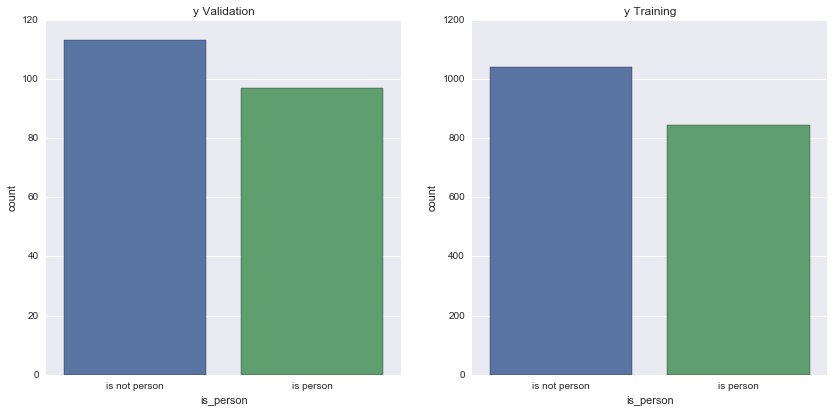

In [7]:
fig = plt.figure()

cp_tr = fig.add_subplot(222)
cp_tr = sns.countplot(x=y_tr)
cp_tr.set_title('y Training')

cp_val = fig.add_subplot(221)
cp_val = sns.countplot(x=y_val)
cp_val.set_title('y Validation')

cp_val.set_xticklabels(['is not person', 'is person'])
cp_tr.set_xticklabels(['is not person', 'is person'])

fig.set_figwidth(14)
fig.set_figheight(14)
plt.show()

### ========== Question 1.6 ==========
What would be a good choice for a baseline classifier to compare your results in the next steps against? What classification accuracy score does the baseline classifier achieve in the validation set?

We can simply use the prior. Thus, we would always predict that the image is not a person. A random image is more likely to be not a person.


In [8]:
accuracy_score = 1 - sum(y_val)/y_val.shape[0]
print ("With this baseline classifier, the classification accuracy score would be ~{} for the validation set.".format(accuracy_score.round(3)))

With this baseline classifier, the classification accuracy score would be ~0.538 for the validation set.


### ========== Question 1.7 ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score in the training and validation sets and compare to that of the baseline classifier. Comment in 1-2 sentences the results. You may include any additional plot(s) if you wish to justify your explanation.

In [9]:
# create the classifier
logreg = LogisticRegression(solver='lbfgs')

# fit the data.
logreg.fit(X_tr, y_tr)

print('Classification accuracy on training set: {:.3f}'.format(logreg.score(X_tr, y_tr)))
print('Classification accuracy on validation set: {:.3f}'.format(logreg.score(X_val, y_val)))

Classification accuracy on training set: 0.552
Classification accuracy on validation set: 0.538


The accuracy of this is awful compared to the baseline. We need to scale data.

 

### ========== Question 1.8 ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [10]:
np.set_printoptions(precision=3)
for i in range(5):
    print('dim{}'.format(str(i+1)))
    mean = X_tr['dim{}'.format(str(i+1))].mean()
    std = X_tr['dim{}'.format(str(i+1))].std()
    print("Mean: {:.5f} \nStandard Deviation: {:.5f}\n".format(mean, std))

dim1
Mean: 0.00175 
Standard Deviation: 0.00120

dim2
Mean: 0.00076 
Standard Deviation: 0.00140

dim3
Mean: 0.00431 
Standard Deviation: 0.00372

dim4
Mean: 0.00185 
Standard Deviation: 0.00134

dim5
Mean: 0.00226 
Standard Deviation: 0.00160



### ========== Question 1.9 ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers an [implementation](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Create a standardiser and fit it by using training features only. Then transform both your input and validation input features. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. 

**IMPORTANT: You should use the transformed data for the rest of part A**.

In [11]:
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)

for i in range(5):
    print('dim{}'.format(str(i+1)))
    mean = X_tr[:,i].mean()
    std = X_tr[:,i].std()
    print("Mean Training: {:.5f} \nStandard Deviation Training: {:.5f}\n".format(mean, std))
    
print("__________________________________________\n__________________________________________\n")

for i in range(5):
    print('dim{}'.format(str(i+1)))
    mean = X_val[:,i].mean()
    std = X_val[:,i].std()
    print("Mean Validation: {:.5f} \nStandard Deviation Validation: {:.5f}\n".format(mean, std))
    

dim1
Mean Training: -0.00000 
Standard Deviation Training: 1.00000

dim2
Mean Training: -0.00000 
Standard Deviation Training: 1.00000

dim3
Mean Training: -0.00000 
Standard Deviation Training: 1.00000

dim4
Mean Training: -0.00000 
Standard Deviation Training: 1.00000

dim5
Mean Training: 0.00000 
Standard Deviation Training: 1.00000

__________________________________________
__________________________________________

dim1
Mean Validation: 0.01602 
Standard Deviation Validation: 0.94242

dim2
Mean Validation: 0.00588 
Standard Deviation Validation: 1.02806

dim3
Mean Validation: 0.02936 
Standard Deviation Validation: 0.93654

dim4
Mean Validation: 0.03111 
Standard Deviation Validation: 1.02519

dim5
Mean Validation: 0.08388 
Standard Deviation Validation: 0.97137



Yes! These results make sense. For the training set, which our scaler was fit to, the standard deviations are exactly 1 and means are exactly 0. Our validation set is similar to the training set but not exactly the same so it makes sense that the means/stds are slightly different but still close to 0.0/1.0 ! :)

### ========== Question 1.10 ==========
By using the transformed input data, retrain a `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy in both the training and validation sets. How does your model compare to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [12]:
logreg.fit(X_tr, y_tr)

print('Classification accuracy on preprocessed training set: {:.3f}'.format(logreg.score(X_tr, y_tr)))
print('Classification accuracy on preprocessed validation set: {:.3f}'.format(logreg.score(X_val, y_val)))

Classification accuracy on preprocessed training set: 0.834
Classification accuracy on preprocessed validation set: 0.600


Our classifier does much better on the training set and slightly better on the validation set. This is certainly an improvement and now it outperforms the baseline classifier which is a good sign.


### ========== Question 1.11 ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes for the weight vector. Thus, it helps us prevent overfitting and, for logistic regression, it additionally controls the level of confidence in making predictions.

We would like to optimise this parameter **by using the transformed training dataset only** and not the validation set. Create a 3-fold cross-validation object for the training dataset. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples in each iteration fold.

In [13]:
kf = KFold(X_tr.shape[0], n_folds=3, shuffle=True, random_state=0)
i = 1
for train, test in kf:
    train_X = X_tr[train, :]; train_y = y_tr.iloc[train] # split training set
    test_X = X_tr[test, :]; test_y = y_tr.iloc[test] # split test set
    print("Fold #{}:\nNumber of Training Points: {} \nNumber of Test Points: {}".format(i, train_X.shape[0], test_X.shape[0]))
    print("Percent is_person Train: {}%".format(round(100.0 * train_y.mean(),2)))
    print("Percent is_person Test: {}%\n".format(round(100.0 * test_y.mean(),2)))
    i = i + 1

Fold #1:
Number of Training Points: 1255 
Number of Test Points: 628
Percent is_person Train: 44.78%
Percent is_person Test: 44.75%

Fold #2:
Number of Training Points: 1255 
Number of Test Points: 628
Percent is_person Train: 44.46%
Percent is_person Test: 45.38%

Fold #3:
Number of Training Points: 1256 
Number of Test Points: 627
Percent is_person Train: 45.06%
Percent is_person Test: 44.18%



### ========== Question 1.12 ========== 
Now we want to test out different settings for the regularisation parameter `C` by using the cross-validation iterator from the previous question. For each iteration, we want to train multiple classifiers by using a range of values for `C` and then compute the performance within each CV fold. You should use a log-range for `C` from `1e-5` to `1e5` by using 20 equally-spaced values *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters.

*(hint: your may want to use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [14]:
logspace = np.logspace(-5, 5, 20)
foldnum = 0
j = 0

score_array = np.zeros([3,20]) #create empty array to score classification accuracies

for train, test in kf:
    train_X = X_tr[train, :]; train_y = y_tr.iloc[train] # split training set
    test_X = X_tr[test, :]; test_y = y_tr.iloc[test] # split test set
    foldnum = foldnum + 1
    j=1
    #print("\n===============================\n")
    
    for c in logspace:
            j = j + 1
            logregtest = LogisticRegression(solver='lbfgs', C = c)
            logregtest.fit(train_X, train_y)
            validation_score = logregtest.score(test_X, test_y)
            score_array[foldnum-1,j-2] = validation_score
            #print("{}: KFold #{}     C: {:.5f}".format(j-1, foldnum-1, c))
            #print('Classification accuracy on preprocessed training set: {:.6f}'.format(logregtest.score(train_X, train_y)))
            #print('Classification accuracy on preprocessed validation set: {:.6f}\n'.format(validation_score))  

print(score_array)

[[ 0.553  0.629  0.666  0.689  0.705  0.707  0.694  0.664  0.635  0.637
   0.621  0.621  0.623  0.621  0.621  0.619  0.621  0.619  0.619  0.621]
 [ 0.546  0.632  0.662  0.674  0.68   0.707  0.691  0.674  0.651  0.637
   0.616  0.599  0.599  0.591  0.584  0.586  0.586  0.586  0.586  0.586]
 [ 0.566  0.644  0.679  0.687  0.694  0.699  0.699  0.689  0.681  0.662
   0.654  0.638  0.638  0.64   0.638  0.635  0.638  0.638  0.638  0.638]]


### ========== Question 1.13 ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

<function matplotlib.pyplot.show>

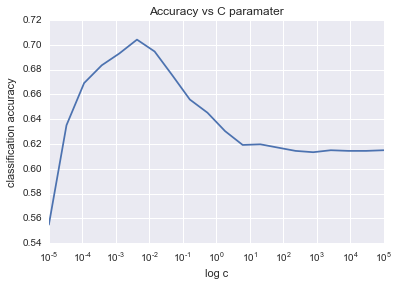

In [15]:
avg_scores = []
for i in range(0,20):
    avg_scores.append(np.mean(score_array[:,i]))
    

plt.semilogx(logspace, avg_scores)
plt.xlabel("log c")
plt.ylabel("classification accuracy")
plt.title("Accuracy vs C paramater")
plt.show

### ========== Question 1.14 ==========
Find and display the optimal value for the regularisation parameter `C` of the logistic classifier by using your results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [16]:
best_index = avg_scores.index(max(avg_scores))
optimalC = logspace[best_index]
print("Optimal C value: {:.8f}".format(optimalC))

Optimal C value: 0.00428133


### ========== Question 1.15 ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Can you verify that your results are consistent with those from Question 1.14?

In [17]:
logregCV = LogisticRegressionCV(Cs=logspace, cv = kf, solver='lbfgs')
logregCV.fit(X_tr, y_tr)
optimalC = logregCV.C_
validation_score = logregtest.score(X_val, y_val)
print("optimal C: {}".format(optimalC))


optimal C: [ 0.004]


### ========== Question 1.16 ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 31 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [23]:
# Your code goes here
rf = RandomForestClassifier(n_estimators=500, random_state = 31)
rf.fit(X_tr, y_tr)
prediction_training = rf.predict(X=X_tr)
prediction_validation = rf.predict(X=X_val)
print('Classification accuracy on training set: {}'.format(accuracy_score(y_tr, prediction_training)))
print('Classification accuracy on validation set: {}'.format(accuracy_score(y_val, prediction_validation)))

Classification accuracy on training set: 1.0
Classification accuracy on validation set: 0.642857142857


### ========== Question 1.17 ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

The results make sense. The forest was perfectly successful on the training set, which makes sense because it is a decision tree classifier and it was reasonably successful on the validation set although not incredibly impressive. The discrepancy is not at all surprising as decision tree classifiers will inherantly overfit data.


### ========== Question 1.18 ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [24]:
importance_array = rf.feature_importances_
best_indicies = np.argsort(importance_array)[::-1]

print("50 Most Important Features\n")
for i in range(0,50):
    index = best_indicies[i]
    dim = input_features[index]
    importance = importance_array[index]
    print("{}: {}  (Importance: {:.6f})".format(i+1, dim, importance))


50 Most Important Features

1: dim21  (Importance: 0.008544)
2: dim479  (Importance: 0.008530)
3: dim343  (Importance: 0.007043)
4: dim4  (Importance: 0.006903)
5: dim461  (Importance: 0.006462)
6: dim76  (Importance: 0.006304)
7: dim360  (Importance: 0.006250)
8: dim283  (Importance: 0.006034)
9: dim51  (Importance: 0.005966)
10: dim74  (Importance: 0.005150)
11: dim485  (Importance: 0.005147)
12: dim348  (Importance: 0.004960)
13: dim356  (Importance: 0.004923)
14: dim92  (Importance: 0.004608)
15: dim483  (Importance: 0.004601)
16: dim330  (Importance: 0.004597)
17: dim263  (Importance: 0.004453)
18: dim398  (Importance: 0.004433)
19: dim96  (Importance: 0.004392)
20: dim54  (Importance: 0.004272)
21: dim222  (Importance: 0.004173)
22: dim274  (Importance: 0.004164)
23: dim154  (Importance: 0.003964)
24: dim288  (Importance: 0.003924)
25: dim73  (Importance: 0.003793)
26: dim217  (Importance: 0.003782)
27: dim17  (Importance: 0.003684)
28: dim289  (Importance: 0.003630)
29: dim353  

### ========== Question 1.19 ==========
Next, we would like to test out the performance of support vector classification and experiment with different kernels. 
By using training data only and default parameter settings, train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [25]:
# build and fit different support vector classifiers
svc_rbf = SVC(kernel='rbf', random_state = 0)
svc_rbf.fit(X_tr, y_tr)

svc_linear = SVC(kernel='linear', random_state = 0)
svc_linear.fit(X_tr, y_tr)

svc_poly = SVC(kernel='poly', random_state = 0)
svc_poly.fit(X_tr, y_tr)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# Report classification accuracy of the training and validation sets
print('Accuracies of Different Types of Support Vector Classifiers on Training and Validation Sets:')

print('RBF accuracy - training set: {:.5f}'.format(svc_rbf.score(X_tr, y_tr)))
print('RBF accuracy - validation set: {:.5f}'.format(svc_rbf.score(X_val, y_val)))

print('Linear accuracy - training set: {:.5f}'.format(svc_linear.score(X_tr, y_tr)))
print('Linear accuracy - validation set: {:.5f}'.format(svc_linear.score(X_val, y_val)))

print('Poly accuracy - training set: {:.5f}'.format(svc_poly.score(X_tr, y_tr)))
print('Poly accuracy - validation set: {:.5f}'.format(svc_poly.score(X_val, y_val)))

Accuracies of Different Types of Support Vector Classifiers on Training and Validation Sets:
RBF accuracy - training set: 0.91184
RBF accuracy - validation set: 0.71429
Linear accuracy - training set: 0.86564
Linear accuracy - validation set: 0.60476
Poly accuracy - training set: 0.99044
Poly accuracy - validation set: 0.67619


### ========== Question 1.20 ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the results by using 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [27]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

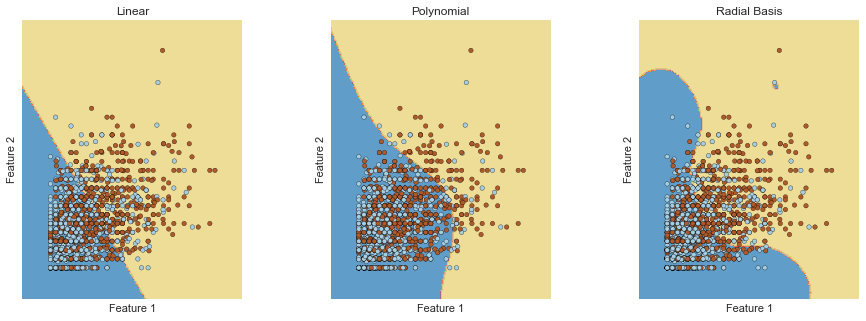

In [28]:
X_tr_2d = X_tr[:, [20,75]]

svc_rbf_2d = SVC(kernel='rbf', random_state = 0)
svc_rbf_2d.fit(X_tr_2d, y_tr)

svc_linear_2d = SVC(kernel='linear', random_state = 0)
svc_linear_2d.fit(X_tr_2d, y_tr)

svc_poly_2d = SVC(kernel='poly', random_state = 0)
svc_poly_2d.fit(X_tr_2d, y_tr)

classifiers = [svc_linear_2d, svc_poly_2d, svc_rbf_2d]
titles = ['Linear', 'Polynomial', 'Radial Basis']
show_svc_decision_boundaries(clfs = classifiers, X = X_tr_2d, title=titles)

These look like they correctly classify 55-70% of the data which is exactly what our accuracy scores said so they are consistent. Radial basis had the highest accuracy and seems to have the best decision boundary so that makes sense. (vice versa for linear!)


### ========== Question 1.21 ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [29]:
logspace = np.logspace(-2, 3, 10)
foldnum = 0
j = 0

score_array = np.zeros([3,10]) #create empty array to score classification accuracies

for train, test in kf:
    train_X = X_tr[train, :]; train_y = y_tr.iloc[train] # split training set
    test_X = X_tr[test, :]; test_y = y_tr.iloc[test] # split test set
    foldnum = foldnum + 1
    j=1
    #print("\n===============================\n")
    
    for c in logspace:
            j = j + 1
            svc = SVC(C = c, kernel='rbf', random_state = 0, gamma = 'auto')
            svc.fit(train_X, train_y)
            validation_score = svc.score(test_X, test_y)
            score_array[foldnum-1,j-2] = validation_score
            #print("{}: KFold #{}     C: {:.5f}".format(j-1, foldnum-1, c))
            #print('Classification accuracy on preprocessed training set: {:.6f}'.format(svc.score(train_X, train_y)))
            #print('Classification accuracy on preprocessed validation set: {:.6f}\n'.format(validation_score))  

print(score_array)

[[ 0.553  0.554  0.683  0.709  0.713  0.704  0.704  0.704  0.704  0.704]
 [ 0.546  0.546  0.693  0.717  0.723  0.71   0.71   0.71   0.71   0.71 ]
 [ 0.558  0.558  0.713  0.737  0.711  0.699  0.699  0.699  0.699  0.699]]


Optimal C value: 0.46415888
Classification accuracy on preprocessed training set: 0.828465
Classification accuracy on preprocessed validation set: 0.680952



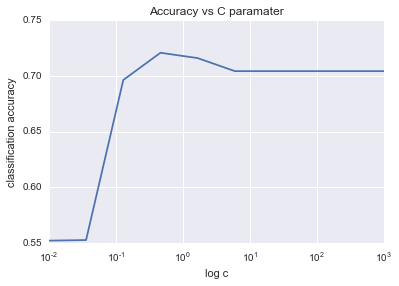

In [30]:
avg_scores = []
for i in range(0,10):
    avg_scores.append(np.mean(score_array[:,i]))
    

plt.semilogx(logspace, avg_scores)
plt.xlabel("log c")
plt.ylabel("classification accuracy")
plt.title("Accuracy vs C paramater")
plt.show

best_index = avg_scores.index(max(avg_scores))
optimalC = logspace[best_index]
print("Optimal C value: {:.8f}".format(optimalC))

svc = SVC(C = optimalC, kernel='rbf', random_state = 0, gamma = 'auto')
svc.fit(X_tr, y_tr)
validation_score = svc.score(X_val, y_val)
print('Classification accuracy on preprocessed training set: {:.6f}'.format(svc.score(X_tr, y_tr)))
print('Classification accuracy on preprocessed validation set: {:.6f}\n'.format(validation_score))  


### ========== Question 1.22 ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [31]:
logspace = np.logspace(-5, 0, 10)
foldnum = 0
j = 0

score_array = np.zeros([3,10]) #create empty array to score classification accuracies

for train, test in kf:
    train_X = X_tr[train, :]; train_y = y_tr.iloc[train] # split training set
    test_X = X_tr[test, :]; test_y = y_tr.iloc[test] # split test set
    foldnum = foldnum + 1
    j=1
    #print("\n===============================\n")
    
    for g in logspace:
            j = j + 1
            svc = SVC(C = 1.0, kernel='rbf', random_state = 0, gamma = g)
            svc.fit(train_X, train_y)
            validation_score = svc.score(test_X, test_y)
            score_array[foldnum-1,j-2] = validation_score
            #print("{}: KFold #{}     Gamma: {:.5f}".format(j-1, foldnum-1, c))
            #print('Classification accuracy on preprocessed training set: {:.6f}'.format(svc.score(train_X, train_y)))
            #print('Classification accuracy on preprocessed validation set: {:.6f}\n'.format(validation_score))  

print(score_array)

[[ 0.553  0.654  0.691  0.718  0.728  0.694  0.553  0.553  0.553  0.553]
 [ 0.546  0.659  0.685  0.709  0.726  0.71   0.548  0.546  0.546  0.546]
 [ 0.558  0.681  0.711  0.71   0.732  0.716  0.56   0.558  0.558  0.558]]


Optimal gamma value: 0.00166810
Classification accuracy on preprocessed training set: 0.886352
Classification accuracy on preprocessed validation set: 0.690476



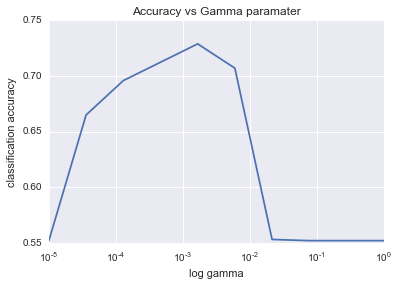

In [33]:
avg_scores = []
for i in range(0,10):
    avg_scores.append(np.mean(score_array[:,i]))
    

plt.semilogx(logspace, avg_scores)
plt.xlabel("log gamma")
plt.ylabel("classification accuracy")
plt.title("Accuracy vs Gamma paramater")
plt.show

best_index = avg_scores.index(max(avg_scores))
optimal_gamma = logspace[best_index]
print("Optimal gamma value: {:.8f}".format(optimal_gamma))

svc = SVC(C = 1.0, kernel='rbf', random_state = 0, gamma = optimal_gamma)
svc.fit(X_tr, y_tr)
validation_score = svc.score(X_val, y_val)
print('Classification accuracy on preprocessed training set: {:.6f}'.format(svc.score(X_tr, y_tr)))
print('Classification accuracy on preprocessed validation set: {:.6f}\n'.format(validation_score))  


### ========== Question 1.23 ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

In [37]:
logspace_gamma = np.logspace(-4, -1, 4)
logspace_c = np.logspace(-2, 1, 4)
score_array = np.zeros([3,4,4])
foldnum = 0
g_num = 0
c_num = 0

for train, test in kf:
    train_X = X_tr[train, :]; train_y = y_tr.iloc[train] # split training set
    test_X = X_tr[test, :]; test_y = y_tr.iloc[test] # split test set

    for g in logspace_gamma:
        for c in logspace_c:
            svc = SVC(C = c, kernel='rbf', random_state = 0, gamma = g)
            svc.fit(train_X, train_y)
            validation_score = svc.score(test_X, test_y)
            score_array[foldnum, c_num, g_num] = validation_score
            c_num += 1
        c_num = 0
        g_num += 1
    g_num = 0
    foldnum += 1
    
print("Task complete.")

Task complete.


Optimal gamma value: 0.001
Optimal c value: 1.000
Classification accuracy on preprocessed training set: 0.833776
Classification accuracy on preprocessed validation set: 0.690476



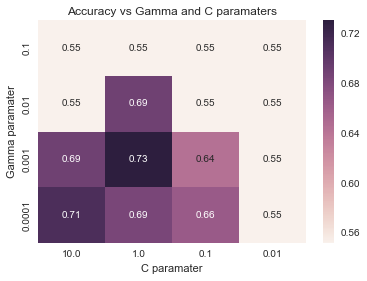

In [38]:
avg_scores = np.zeros([4,4])
for i in range(0,4):
    for j in range(0,4):
        avg_scores[i,j] = np.mean(score_array[:,i,j])
    
ax = heatmap(avg_scores, annot = True)
ax.set_xticklabels(np.logspace(1, -2, 4))
ax.set_yticklabels(logspace_gamma)
ax.set_xlabel("C paramater")
ax.set_ylabel("Gamma paramater")
ax.set_title("Accuracy vs Gamma and C paramaters")

best_index = np.argmax(avg_scores)
best_indicies = unravel_index(avg_scores.argmax(), avg_scores.shape)
optimal_gamma = logspace_gamma[best_indicies[1]]
optimal_c = logspace_c[best_indicies[0]]

print("Optimal gamma value: {:.3f}".format(optimal_gamma))
print("Optimal c value: {:.3f}".format(optimal_c))

svc = SVC(C = optimal_c, kernel='rbf', random_state = 0, gamma = optimal_gamma)
svc.fit(X_tr, y_tr)
validation_score = svc.score(X_val, y_val)
print('Classification accuracy on preprocessed training set: {:.6f}'.format(svc.score(X_tr, y_tr)))
print('Classification accuracy on preprocessed validation set: {:.6f}\n'.format(validation_score))  


### ========== Question 1.24 ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

Our accuracy is not significantly higher! 

In theory it should be. We found optimal c values and gamma values earlier but those were not an optimal *combination* of values.

We could look closely around our previous optimum points and then iterate very close to them for better results. I will try that in part 2.

### ========== Question 1.25 ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [43]:
degrees = np.arange(1,8)
foldnum = 0
j = 0
score_array = np.zeros([3,7]) #create empty array to score classification accuracies

for train, test in kf:
    train_X = X_tr[train, :]; train_y = y_tr.iloc[train] # split training set
    test_X = X_tr[test, :]; test_y = y_tr.iloc[test] # split test set
    foldnum = foldnum + 1
    j=1
    
    for d in degrees:
            j = j + 1
            svc = SVC(degree=d, kernel='poly',  random_state = 0)
            svc.fit(train_X, train_y)
            validation_score = svc.score(test_X, test_y)
            score_array[foldnum-1,j-2] = validation_score
            
print(score_array)

[[ 0.712  0.656  0.693  0.627  0.613  0.564  0.527]
 [ 0.723  0.675  0.689  0.654  0.591  0.57   0.559]
 [ 0.695  0.692  0.675  0.609  0.585  0.577  0.569]]


Optimal degree: 1.00000000
Classification accuracy on preprocessed training set: 0.790759
Classification accuracy on preprocessed validation set: 0.638095



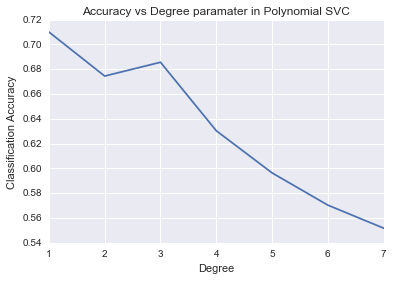

In [46]:
avg_scores = []
for i in range(0,7):
    avg_scores.append(np.mean(score_array[:,i]))
    

plt.plot(degrees, avg_scores)
plt.xlabel("Degree")
plt.ylabel("Classification Accuracy")
plt.title("Accuracy vs Degree paramater in Polynomial SVC")
plt.show

best_index = avg_scores.index(max(avg_scores))
optimal_degree = degrees[best_index]
print("Optimal degree: {:.8f}".format(optimal_degree))

svc = SVC(kernel='poly', random_state = 0, degree = optimal_degree)
svc.fit(X_tr, y_tr)
validation_score = svc.score(X_val, y_val)
print('Classification accuracy on preprocessed training set: {:.6f}'.format(svc.score(X_tr, y_tr)))
print('Classification accuracy on preprocessed validation set: {:.6f}\n'.format(validation_score))  


### ========== Question 1.26 ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

Cross validation lets us train with all of our data and lets us bypass irregularities in the initial split between training and validation sets. However, it is more computationally expensive and doesn't always change results significantly so sometimes it is smart to be careful how many folds you are using.

### ========== Question 1.27 ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [98]:
# Load the datasets
data_path1 = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A_2 = pd.read_csv(data_path1, delimiter = ',')

data_path2 = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A_2 = pd.read_csv(data_path2, delimiter = ',')



In [99]:
# Get the input features into a list (removed imgID and is_person)
input_features = train_A_2.columns[1:514].values.tolist()
input_features.extend(train_A_2.columns[516:519].values.tolist())

In [100]:
#pull input features and target
X_train = train_A_2[input_features]
y_train = train_A_2['is_person']

X_test = valid_A_2[input_features]
y_test = valid_A_2['is_person']

#print details
print('X_train shape: {}'.format(np.shape(X_train)))
print('y_train shape: {}'.format(np.shape(y_train)))
print('X_test shape: {}'.format(np.shape(X_test)))
print('y_test shape: {}'.format(np.shape(y_test)))

X_train shape: (2093, 516)
y_train shape: (2093,)
X_test shape: (1113, 516)
y_test shape: (1113,)


In [101]:
# Scale data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [102]:
# Your code goes here
rf = RandomForestClassifier(n_estimators=518, random_state = 31)
rf.fit(X_train, y_train)
prediction_training = rf.predict(X=X_train)
prediction_validation = rf.predict(X=X_test)
print('Classification accuracy on training set: {}'.format(accuracy_score(y_train, prediction_training)))
print('Classification accuracy on validation set: {}'.format(accuracy_score(y_test, prediction_validation)))

Classification accuracy on training set: 1.0
Classification accuracy on validation set: 0.725965858041


In [103]:
importance_array = rf.feature_importances_
best_indicies = np.argsort(importance_array)[::-1]

print("50 Most Important Features\n")
for i in range(0,50):
    index = best_indicies[i]
    dim = input_features[index]
    importance = importance_array[index]
    print("{}: {}  (Importance: {:.6f})".format(i+1, dim, importance))


50 Most Important Features

1: is_cat  (Importance: 0.010308)
2: is_bird  (Importance: 0.007568)
3: dim51  (Importance: 0.007509)
4: dim21  (Importance: 0.007460)
5: dim360  (Importance: 0.007191)
6: dim479  (Importance: 0.006623)
7: dim398  (Importance: 0.005806)
8: dim283  (Importance: 0.005777)
9: dim76  (Importance: 0.005536)
10: dim4  (Importance: 0.005491)
11: dim222  (Importance: 0.005289)
12: dim74  (Importance: 0.005113)
13: dim461  (Importance: 0.004604)
14: dim92  (Importance: 0.004589)
15: dim214  (Importance: 0.004549)
16: dim485  (Importance: 0.004505)
17: dim274  (Importance: 0.004247)
18: dim356  (Importance: 0.004194)
19: dim217  (Importance: 0.004175)
20: dim343  (Importance: 0.004102)
21: dim254  (Importance: 0.004101)
22: dim348  (Importance: 0.004096)
23: dim90  (Importance: 0.004080)
24: dim330  (Importance: 0.004046)
25: dim483  (Importance: 0.003976)
26: dim347  (Importance: 0.003931)
27: dim326  (Importance: 0.003920)
28: dim423  (Importance: 0.003900)
29: dim7

Our performance went up. This makes complete since because we are introducing more data about the training set. Furthermore, the type of data we are introducing is very valuable. Most of the pictures contain one object. Thus, if we know it is a picture of say, a bird, then we know it is NOT a picture of a person. Thus, is_bird is a valuable attribute. It seems that if this attribute has a value of 1 then is_person is likely to have a value of zero. The opposite may not definitely be true but it has a higher probability.


## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classiffier you like (with the provison that you can explain what the classiffier/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the posterior probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated posterior probabilities for the data points in the test set into a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. You are then required to copy this file into your submission folder along with your notebook (see Mecanics section at the top of the notebook) and then submit the two files by using the `submit` command on DICE. You are only required to use the `submit` command once.

*Your answer goes here (max. 600 words)*



In [105]:
# Load the datasets
data_path1 = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
train_B = pd.read_csv(data_path1, delimiter = ',')

data_path2 = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
valid_B = pd.read_csv(data_path2, delimiter = ',')

data_path3 = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
test_B = pd.read_csv(data_path2, delimiter = ',')

# Get the input features into a list (removed labels)
input_features = train_B.columns[1:501].tolist()

#pull input features and target
X_train = train_B[input_features]
y_train = train_B['is_person']

X_val = valid_B[input_features]
y_val = valid_B['is_person']

X_test = test_B[input_features]


<h2>Try different scaling methods:</h2>

In [100]:
# Scale data using three different methods
scaler = StandardScaler().fit(X_train) # standard scaler
min_max_scaler = MinMaxScaler().fit(X_train) # min-max scaler
robust_scaler = RobustScaler().fit(X_train) # robust scaler

X_train_min_max_scaled = min_max_scaler.transform(X_train)
X_val_min_max_scaled = min_max_scaler.transform(X_val)

X_train_standard_scaled = scaler.transform(X_train)
X_val_standard_scaled = scaler.transform(X_val) 

# tested with different scales and this was the best one
X_train_robust = robust_scaler.transform(X_train)
X_val_robust = robust_scaler.transform(X_val) 
X_test_robust = robust_scaler.transform(X_test)
print("done")

done


<h2> kNN attempt with optimized k:</h2>

In [38]:
# try kNN and optimize k
best_accuracy = 0.0

k_vals = np.linspace(1,46,16)
k_opt = -1
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_robust, y_train)
    score = knn.score(X_val_robust, y_val)
    if score > best_accuracy:
        best_accuracy = score
        k_opt = k
    #print('{}: KNN classification accuracy (k = {}) on training set: {:.3f}'.format(k,k, score))
print ("Optimal K: {} Best accuracy: {}".format(k_opt, best_accuracy))

Optimal K: 28.0 Best accuracy: 0.677448337826


<h2>SVC attempt with Radial Basis and RobustScaler</h2>

In [88]:
svc_rbf = SVC(kernel='rbf', random_state = 0, probability = True)
svc_rbf.fit(X_train_robust, y_train)
validation_score = svc_rbf.score(X_val_robust, y_val)
print('Classification accuracy on preprocessed validation set: {:.6f}\n'.format(validation_score))  

Classification accuracy on preprocessed validation set: 0.710692



<h2>SVC attempt with Polynomials and RobustScaler</h2>

In [44]:
svc_poly = SVC( kernel='poly', random_state = 0)
svc_poly.fit(X_train_robust, y_train)
validation_score = svc_poly.score(X_val_robust, y_val)
print('Polynomial Classification accuracy on preprocessed validation set: {:.6f}\n'.format(validation_score))  

Polynomial Classification accuracy on preprocessed validation set: 0.694519



<h2>SVC attempt with PCA Dimensionality Reduction</h2>

In [52]:
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_robust, y = y_train) 
X_val_pca = pca.transform(X_val_robust)

svc_radial_basis = SVC(kernel='rbf', random_state = 0)
svc_radial_basis.fit(X_train_pca, y_train)
print('RBF accuracy - validation set: {:.5f}'.format(svc_radial_basis.score(X_val_pca, y_val)))

RBF accuracy - validation set: 0.69632


<h2>Random Forest attempt with RobustScaler</h2>

In [45]:
# Your code goes here
rf = RandomForestClassifier(n_estimators=499, random_state = 31)
rf.fit(X_train_robust, y_train)
prediction_training = rf.predict(X=X_train_robust)
prediction_validation = rf.predict(X=X_val_robust)
print('Classification accuracy on validation set: {}'.format(accuracy_score(y_val, prediction_validation)))

Classification accuracy on validation set: 0.703504043127


<h2>Random Forest attempt with 50 most important attributes</h2>

In [49]:
importance_array = rf.feature_importances_
best_indicies = np.argsort(importance_array)[::-1]

#pull input features and target
X_train_50 = train_B[best_indicies[0:50]]
X_val_50 = valid_B[best_indicies[0:50]]

# Your code goes here
rf_50 = RandomForestClassifier(n_estimators=499, random_state = 31)
rf_50.fit(X_train_50, y_train)
prediction_training = rf_50.predict(X=X_train_50)
prediction_validation = rf_50.predict(X=X_val_50)
print('Classification accuracy on validation set: {}'.format(accuracy_score(y_val, prediction_validation)))

Classification accuracy on validation set: 0.661275831087


<h2>Playing around with optimizing c and gamma for SVC -- Unsuccessful</h2>

In [54]:
# logspaces centred around previous optimized points
logspace_gamma = np.logspace(-2, 1, 4)
logspace_c = np.logspace(-4, -1, 4)

scores_array = np.zeros([4,4])
g_num = 0
c_num = 0

for g in logspace_gamma:
    for c in logspace_c:
            svc_test = SVC(kernel='rbf', random_state = 0, gamma = g, C = c)
            #svc_test = SVC(kernel='rbf', random_state = 0)
            svc_test.fit(X_train_standard_scaled, y_train)
            scores_array[c_num, g_num] = svc_test.score(X_val_standard_scaled, y_val)
            c_num += 1
    c_num = 0
    g_num += 1

print("Task complete.")

Task complete.


In [60]:
best_index = scores_array.argmax()
best_indicies = unravel_index(scores_array.argmax(), scores_array.shape)
optimal_gamma = logspace_gamma[best_indicies[1]]
optimal_c = logspace_c[best_indicies[0]]

print("Optimal gamma value: {:.3f}".format(optimal_gamma))
print("Optimal c value: {:.3f}".format(optimal_c))  


Optimal gamma value: 10.000
Optimal c value: 0.100


In [101]:
pred_proba = svc_rbf.predict_proba(X_test_robust)

In [102]:
pred_proba.shape
X_test.shape

(1113, 500)

In [97]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1113,2):
        raise ValueError('Predicted probabilities array has not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

save_predictions(pred_proba) # You need to replace "pred_proba" with the name of the array
                             # which contains the probability estimates for the data in 
                             # the test set.

<h2>NOTE:</h2>
My 'test_images_partB.csv' had only 1113 values not 1114. I am not sure why but I had to change the error check in the previous box.

<h4>Possible Successful Methods:</h4>
Support Vector Classifiers with radial basis functions seem to be the best algorithm to use in general. I tried NB classifiers and Decision forests and got very disappointing results, especially for GuassianNB.

A more comprehensive optimization of ‘G’ and ‘C’ parameters in a support vector classifier could be very successful. I would have built very slim log-spaces centered around the initial optimums to fine tune the parameters. 

I played around with different scalers, such as RobustScaler and had some more success, which defends against outliers by using median and interquartile range instead of mean and variance. This did, in fact, give me slightly better performance!

I did some research online and found that a commonly used method of improving learning is to use ensemble methods. There is more than on way to do this. KFold seems to already be a type of bagging method and random forests seem to be a type of boosting method but I think there is a lot more here that could be done. I would investigate this further if I were to be building this model professionally.

Feature engineering could have been useful but I was not exactly sure how to implement it. 

<h4>Most Successful Method:</h4>
Unfortunately, I was not able to attempt all the above methods. SVC attempt with Radial Basis and RobustScaler was my most successful method but I wish I had more time to investigate methods above.

<h4>Unsuccessful Methods:</h4>
Dimensionality Reduction: The first thing I would have tried is a dimensionality reduction, possibly using some sort of clustering. However, I briefly tried using a PCA with limited success. We haven’t covered much about dimensionality reduction but it seemed to just limit the information available for the classifier. When I “reduced” the dimension using PCA from 499 -> 499, the performance was exactly the same and when I went from 499 to any number < 499 I had worse performance.

Feature Importance: I also tried training with only the 50 most important features. This gave similar results to dimensionality reduction.



